Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

tf.get_logger().setLevel('ERROR')

In [3]:
## Mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Data/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Data/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:
## Train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

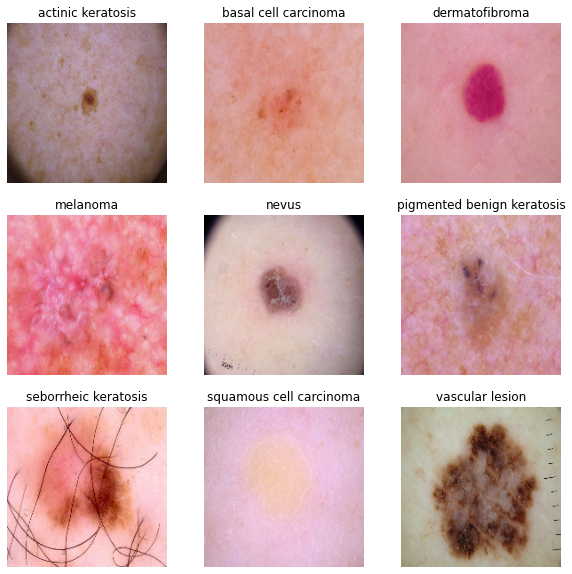

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")    

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create CNN model to accurately detect 9 classes present in the dataset.


In [14]:
input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model


In [15]:

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     2432      
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 180, 180, 32)     25632     
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 90, 90, 32)       25632     
 pper)                                                  

### Train the model

In [17]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 578s 2s/step - loss: 0.3504 - accuracy: 0.1775 - val_loss: 0.3290 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 0.3300 - accuracy: 0.1981 - val_loss: 0.3284 - val_accuracy: 0.1588
Epoch 3/20
56/56 [==============================] - 5s 91ms/step - loss: 0.3296 - accuracy: 0.2143 - val_loss: 0.3238 - val_accuracy: 0.2685
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 0.3155 - accuracy: 0.2785 - val_loss: 0.3160 - val_accuracy: 0.2975
Epoch 5/20
56/56 [==============================] - 5s 90ms/step - loss: 0.2983 - accuracy: 0.3292 - val_loss: 0.2863 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 0.2924 - accuracy: 0.3460 - val_loss: 0.2845 - val_accuracy: 0.3624
Epoch 7/20
56/56 [==============================] - 5s 91ms/step - loss: 0.2859 - accuracy: 0.3767 - val_loss: 0.2689 - val_accuracy: 0.4340
Epoch 8/20
56

### Visualizing training results

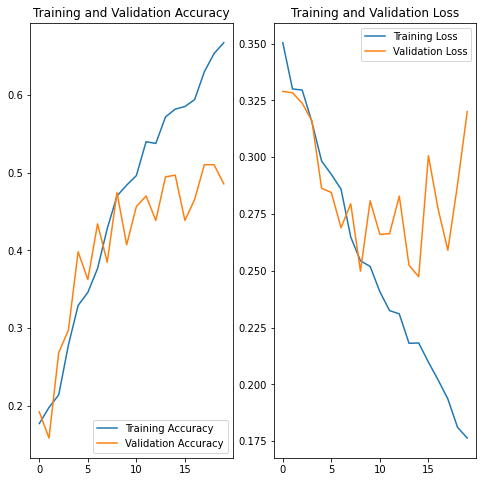

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Overfit or Underfit?

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 25ms/step - loss: 0.3201 - accuracy: 0.4855
Accuracy:  0.6752232313156128
Validation Accuracy:  0.4854586124420166
Loss:  0.1743679940700531
Validation Loss 0.3201075494289398


#### Observations:

1.   The validation loss is higher than training loss, which shows evidence of overfitting
2.   The training accuracy is comparatively better than the validation accuracy which also signifies that model is overfitting

We need to choose the right data augmentation strategy to avoid overfitting.


In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion',
               'dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


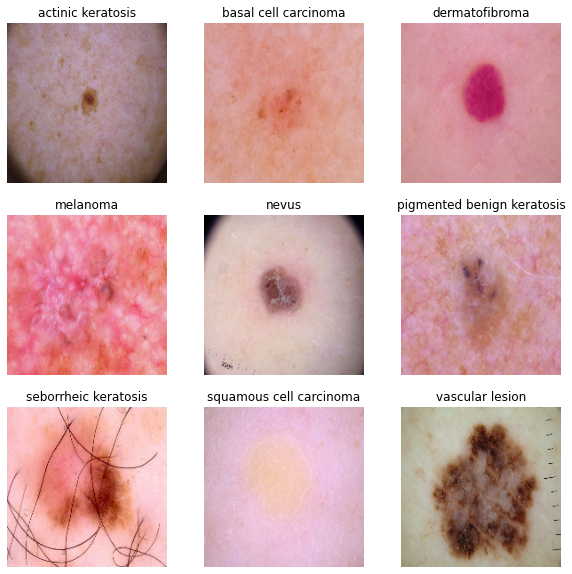

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):

  ax = plt.subplot(3, 3, i + 1)
  # convert to unsigned integers for plotting
  image = next(train_batches)[0][0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[i])
  plt.axis("off")   


### Create the model, compile and train the model


In [22]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

### Compiling the model

In [23]:

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [25]:
## Train model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 85s 6s/step - loss: 1.9386 - accuracy: 0.4326 - val_loss: 1.4743 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 35s 3s/step - loss: 0.9857 - accuracy: 0.4865 - val_loss: 1.4066 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 35s 3s/step - loss: 0.9170 - accuracy: 0.5079 - val_loss: 1.3575 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - 34s 2s/step - loss: 0.8040 - accuracy: 0.5820 - val_loss: 1.1921 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 35s 2s/step - loss: 0.7663 - accuracy: 0.6124 - val_loss: 1.3685 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - 34s 2s/step - loss: 0.8043 - accuracy: 0.5955 - val_loss: 1.3085 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/20
14/14 [==============================] - 35s 2s/step - loss: 0.7345 - a

### Visualizing the results

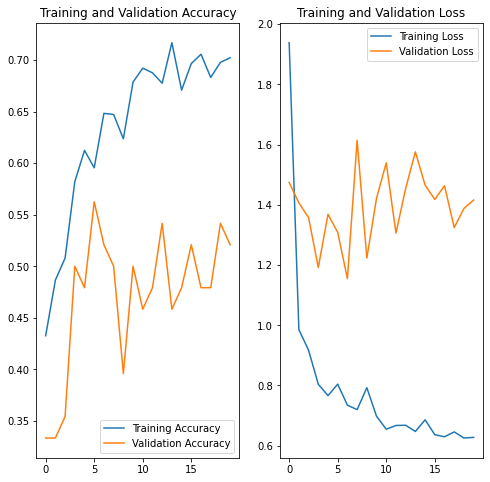

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
loss, accuracy = model.evaluate(train_batches, verbose=1,)
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

1/1 [==============================] - 4s 4s/step - loss: 1.3824 - accuracy: 0.5208
Accuracy:  0.7022472023963928
Validation Accuracy:  0.5208333134651184
Loss:  0.6432300806045532
Validation Loss 1.3823803663253784


#### Observations:

1.   The difference between the validation loss and training loss is fairly similar to the previous model.
2.   The training accuracy has slightly increased as compared to the previous model.

#### Let's Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
1,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
2,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
3,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
4,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2235,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2236,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2237,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion


In [30]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

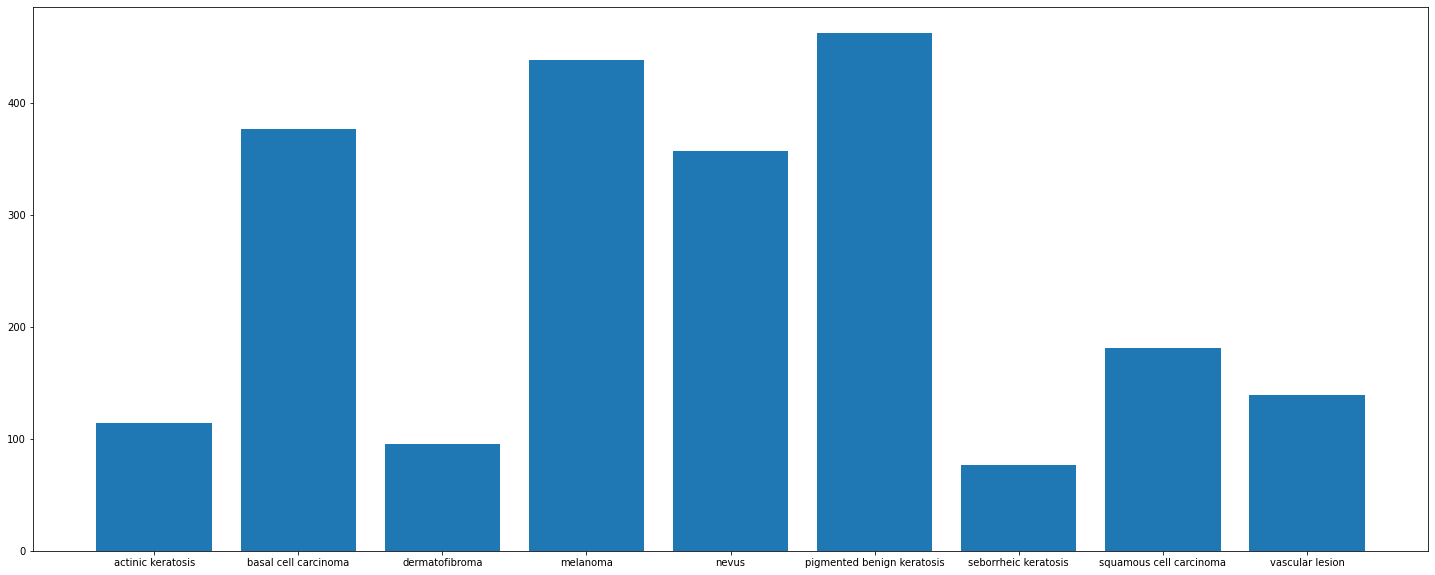

In [31]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?  - **dermatofibroma and Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? - **Pigmented benign keratosis** dominates the data of count more than 100 in training set


#### Let's rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/gdrive/My Drive/Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F8E13E670>: 100%|██████████| 500/500 [00:24<00:00, 20.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F503B0E50D0>: 100%|██████████| 500/500 [00:26<00:00, 18.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F06E3EA00>: 100%|██████████| 500/500 [00:25<00:00, 19.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3008x2000 at 0x7F4F097418B0>: 100%|██████████| 500/500 [01:28<00:00,  5.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4F097F8790>: 100%|██████████| 500/500 [01:41<00:00,  4.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F06663FD0>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4F0AFAF970>: 100%|██████████| 500/500 [00:47<00:00, 10.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F8C0B7280>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4F8C0B03A0>: 100%|██████████| 500/500 [00:19<00:00, 26.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024710.jpg_fd36570e-10b2-46b1-b7a7-c6024cb2c044.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032947.jpg_51cd1625-76db-4384-a3e1-91e9fee43074.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_cc751916-3f1c-42e6-927e-c15cabc25eb4.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026327.jpg_741eebf8-9b3f-4a9e-be6a-2b2457cd56f5.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028231.jpg_734a0809-4ec9-4ca1-a208-cf7bef574bba.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_d806edaa-6e23-42d9-9319-036e775d8abc.jpg',
 '/content/gdrive/My Drive/D

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [41]:
data_dir_train="/content/gdrive/My Drive/Data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model (make sure to include normalization)

In [43]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_27 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_28 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                        

#### Compile model

In [44]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [45]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#### Let's train the model

In [46]:
epochs = 30
history = model.fit(train_ds, epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 45s 245ms/step - loss: 2.0481 - accuracy: 0.3338 - val_loss: 2.8760 - val_accuracy: 0.0846 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 38s 218ms/step - loss: 1.6488 - accuracy: 0.4299 - val_loss: 2.1191 - val_accuracy: 0.2242 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 38s 216ms/step - loss: 1.3361 - accuracy: 0.5117 - val_loss: 1.3521 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 43s 251ms/step - loss: 1.2150 - accuracy: 0.5658 - val_loss: 2.0552 - val_accuracy: 0.3504 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 38s 215ms/step - loss: 1.0771 - accuracy: 0.6100 - val_loss: 1.3751 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 39s 227ms/step - loss: 1.0014 - accuracy: 0.6417 - val_loss: 0.9322 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

#### Let's Visualize the model results

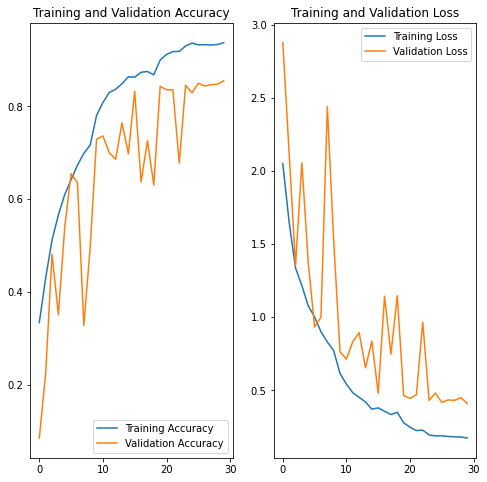

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 8s 153ms/step - loss: 0.4091 - accuracy: 0.8552
Accuracy:  0.9642062187194824
Validation Accuracy:  0.8552338480949402
Loss:  0.08905418962240219
Validation Loss 0.40912580490112305


**Observations:**


1. The class rebalance helped in reducing overfitting of the data and thus the loass is being reduced
2. Accuracy on training data has increased by using Batch Normalization and Augmentation.